### Importando Bibliotecas

In [1]:
#importando bibliotecas
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.utils import shuffle
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Bidirectional,Dropout
from keras.layers import AveragePooling1D
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.metrics import * 
from sklearn.model_selection import KFold 
import os
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-17 15:00:19.100682: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 15:00:19.130017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-17 15:00:19.164696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-17 15:00:19.174471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-17 15:00:19.198434: I tensorflow/core/platform/cpu_feature_guar

### Carregando Dados

In [2]:
df = pd.read_csv('data/reqTxt.csv', header=None) #Report or file containing the set of training and test texts.

In [3]:
dfRequire = df.iloc[:,:] 

In [4]:
print(dfRequire.shape)
print(dfRequire.columns)
X = dfRequire[0]
print(X[0])
X = np.array(X)

print(len(X))

print('Train and test dataset loaded...')

(23313, 1)
Index([0], dtype='int64')
add ca against object literals in function invocationsthe idea here is that if our metadata captures a type as function arg we should be able to create an instance of that type as an object literal as an arg to a function invocation for examplep    tiuicreatelabel  ltpropertycaheregt  code prediv
23313
Train and test dataset loaded...


In [5]:
X

array(['add ca against object literals in function invocationsthe idea here is that if our metadata captures a type as function arg we should be able to create an instance of that type as an object literal as an arg to a function invocation for examplep    tiuicreatelabel  ltpropertycaheregt  code prediv',
       'update branding for appcelerator plugin to appcelerator logoat least fix feature icons associated natures perhaps other screens as wellpdiv',
       'create new json schema for sdk teamcreate json schema containing properties required for proper ca hand schema to platform team to output new docsjson files as part of new sdk releases it may be that instead we can use the vsdoc format in which case we will need to indicate to the sdk team additional items to be added to the docspdiv',
       ...,
       'proof of concept use akka for unique value enforcementby using an distributed actor system we can ensure that only one thread accesses any one unique value at a time i have a w

In [6]:
y = pd.read_csv('data/estiDeep.data', header=None) #File containing the set of training and test labels.
y = np.array(y)
print ('Shape of label tensor:', y.shape)
print(y.dtype)

#Number of texts in train and test dataset 
MAX_LEN = 23313

kf = KFold(n_splits=10, shuffle=True, random_state=1000) 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 


Shape of label tensor: (23313, 1)
int64
KFold(n_splits=10, random_state=1000, shuffle=True)


### Carregando Embeddings ja convertidos
O arquivo Convert embeddings mostra a conversão da base de requisitos em embeddings

In [7]:
#pret_model = pd.read_csv('embeddings_finetuned_FastText.csv', delimiter= ',', header=None) #insert embedding 
pret_model = pd.read_csv('embeddings/embeddings_xlnet.csv', delimiter= ',', header=None) #insert embedding 

embedding_matrix = pret_model.iloc[0:23313,:] 
dfEmbedding_mat = pd.DataFrame(embedding_matrix)
embedding_mat = dfEmbedding_mat.fillna('0') 

print('Embedding mat: ' + str(embedding_mat.shape))

i = 0

Embedding mat: (23313, 768)


### Model 


In [ ]:
all_y_test_Deep = []
all_y_pred_Deep = []
vetMAEDeep = []
vetR2Deep = []
vetMSEDeep = []
vetMdaeDeep = []
vetPred25Deep = []



# Cross-validation loop
for train_index, test_index in kf.split(X):
    x_train, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    texts_train = x_train.astype(str)
    texts_test = test_x.astype(str)

    tokenizer = Tokenizer(num_words=MAX_LEN, char_level=False, lower=False) 
    tokenizer.fit_on_texts(texts_train)                            
    encSequences = tokenizer.texts_to_sequences(texts_train)          
    encSequences_test = tokenizer.texts_to_sequences(texts_test)      

    vocab_size = len(tokenizer.word_index) + 1 
    print('Vocab_size: ' + str(vocab_size))

    MAX_SEQUENCE_LENGTH = 100  # Número de palavras em cada texto

    x_train = pad_sequences(encSequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    x_test = pad_sequences(encSequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    print('Shape of data tensor:', x_train.shape)
    print('Shape of data test tensor:', x_test.shape)

    # Definindo o modelo
    model = Sequential()

    #embedding = Embedding(MAX_LEN, 300, input_length=MAX_SEQUENCE_LENGTH, trainable=True) #Using this for FastText
    embedding = Embedding(MAX_LEN, 768, input_length=MAX_SEQUENCE_LENGTH, trainable=True) #Using this for XLNET
    
    embedding.build(input_shape=(None,))  # O input_shape é ajustado para (None,) para batch size variável
    embedding.set_weights([embedding_mat])
    model.add(embedding)
    
    model.add(AveragePooling1D(pool_size=100))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=False)) 
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = Adam(learning_rate=0.001)  # O parâmetro epsilon é opcional
    model.compile(loss='mse', optimizer=adam, metrics=['mae'])

    model.summary()

    es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)

    model_history = model.fit(x_train, train_y,
              batch_size=128,
              epochs=30, callbacks=[es],
              validation_data=(x_test, test_y))                

    y_pred = model.predict(x_test)

    # Armazenar os resultados
    all_y_test_Deep.extend(test_y.flatten())
    all_y_pred_Deep.extend(y_pred.flatten())

    # Cálculo das métricas
  
    vetPred25Deep.append(pred_25)
    
    mae = mean_absolute_error(test_y, y_pred)
    vetMAEDeep.append(mae)
    medAE = median_absolute_error(test_y, y_pred)
    vetMdaeDeep.append(medAE)
    r2 = r2_score(test_y, y_pred)
    vetR2Deep.append(r2)
    mse = mean_squared_error(test_y, y_pred)
    vetMSEDeep.append(mse)

maeMedio = np.mean(vetMAEDeep)  
madAEMedio = np.mean(vetMdaeDeep)  
r2Medio = np.mean(vetR2Deep)  
mseMedio = np.mean(vetMSEDeep) 



Vocab_size: 89803
Shape of data tensor: (20981, 100)
Shape of data test tensor: (2332, 100)


/home/daniel/mestrado/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-17 15:02:19.288728: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-05-17 15:02:19.288774: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: daniel-Predator-PH315-54
2025-05-17 15:02:19.288785: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: daniel-Predator-PH315-54
2025-05-17 15:02:19.289022: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.144.3
2025-05-17 15:02:19.289060: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.144.3
2025-05-17 15:02:19.289069: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 768)            │    17,904,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ ?                      │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,904,384 (68.30 MB)

 Trainable params: 17,904,384 (68.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - loss: 105.6898 - mae: 4.8702 - val_loss: 93.9284 - val_mae: 4.5020
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 105.2932 - mae: 4.8419 - val_loss: 93.8620 - val_mae: 4.8101
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 105.9339 - mae: 4.9073 - val_loss: 93.7871 - val_mae: 4.5732
Epoch 4/30
 63/164 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 88.0678 - mae: 4.5036

KeyboardInterrupt: 

In [47]:
# Formatar os resultados no formato "média ± desvio padrão"

maeMedio = np.mean(vetMAEDeep)  
madAEMedio = np.mean(vetMdaeDeep)  
r2Medio = np.mean(vetR2Deep)  
mseMedio = np.mean(vetMSEDeep) 
stdMae = np.std(vetMAEDeep)
stdr2 = np.std(vetR2Deep)
stdMse = np.std(vetMSEDeep)


mae_result = f"{maeMedio:.2f} ± {stdMae:.2f}"
mse_result = f"{mseMedio:.2f} ± {stdMse:.2f}"
r2_result = f"{r2Medio:.2f} ± {stdr2:.2f}"
mad_result = f"{madAEMedio:.2f}"  # Se você também quiser calcular o desvio padrão, pode adicionar aqui


# Imprimir os resultados
print('MAE:', mae_result)
print('MSE:', mse_result)
print('R2:', r2_result)
print('MdAE:', mad_result)


MAE: 3.85 ± 0.16
MSE: 78.33 ± 11.59
R2: 0.22 ± 0.06
MdAE: 1.99


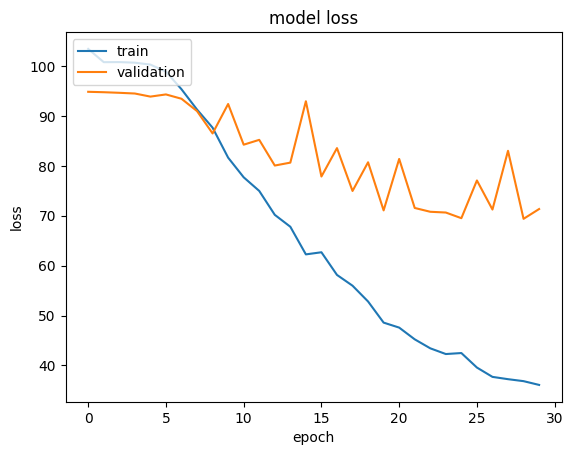

In [48]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [49]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
import joblib
file_name = '../model/pt/deep_learning_pt.pkl' #Documents/Mestrado/Mestrado/Artigo/codigo/model/en/deep_learning_regressao.pkl
joblib.dump(model, file_name) 

['../model/en/deep_learning_regressao.pkl']

In [17]:
import joblib
model = joblib.load('../model/pt/deep_learning_pt.pkl')

In [18]:
model.save('model_deep_learning_regressao_pt.h5')

### Realizando o teste estatístico Wilcoxon e Cohen com as bases de dados

In [2]:
from __future__ import division, print_function
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import collections
import nltk
import numpy as np
import os
import logging
# %matplotlib inline

from glob import glob
import pandas as pd
# this cell is only for checking my data
files = glob('*.csv')
files

[]

### Pré-processamento da base de dados

In [9]:
import nltk  
nltk.download('stopwords')
nltk.download('punkt')

import string
import re
def load_data(file_path):
    new_df = pd.read_csv(file_path)
    new_df.dropna(inplace=True)
    new_df.head(100)
    new_df["description"]=new_df["title"]+" "+ new_df["description"] 
    new_df.head(100)
    new_df.storypoint.value_counts()
    new_df.storypoint.count()
    new_df = pd.read_csv(file_path)
    #just for testing
    new_df.dropna(inplace=True)
    new_df.head(100)
    new_df.storypoint.value_counts()
    new_df=new_df[new_df.storypoint != 40]
    new_df=new_df[new_df.storypoint != 34]
    new_df=new_df[new_df.storypoint != 9]
    new_df.storypoint.value_counts()
    new_df = pd.read_csv(file_path)
    #just for testing
    new_df.dropna(inplace=True)
    new_df.head(100)
    new_df["description"]=new_df["title"]+" "+ new_df["description"] 
    new_df.head(100)

    #new_df["description"]
    #test_df
    new_df.storypoint.value_counts()
    new_df=new_df[new_df.storypoint != 9]
    new_df=new_df[new_df.storypoint != 34]
    new_df.storypoint.value_counts()
    #new_df["description"].head(1)

    new_df.storypoint.count()

    new_df = new_df.sample(3700, replace=True)

    new_df.storypoint.value_counts()

    ##Functions
    def remove_punct(text):


        regex = re.compile('[%s]' % re.escape(string.punctuation))
        text = regex.sub(' ', text)
    #     text = "".join([char for char in text if char not in string.punctuation])
        return text
    TAG_RE = re.compile(r'<[^>]+>')

    def remove_tags(text):
        return TAG_RE.sub('', text)

    def remove_html(text):
        return re.sub(r'{[^}]+}', "", text)

    def remove_URL(text):
    # """Remove URLs from a text string"""
    #   return re.sub(r"http\S+", "", text)
        #return re.sub(r'^https?:\/\/.*[\r\n]*', "", text)
        return re.sub(r'http://\S+|https://\S+', "", text)
    #r'^https?:\/\/.*[\r\n]*'

    new_df["description_withoutpun"] = new_df["description"].dropna().apply(lambda x: remove_URL(x))
    new_df["description_withoutpun"] = new_df["description_withoutpun"].dropna().apply(lambda x: remove_tags(x))

    new_df["description_withoutpun"] = new_df["description_withoutpun"].dropna().apply(lambda x: remove_html(x))
    new_df["description_withoutpun"] = new_df["description_withoutpun"].dropna().apply(lambda x: remove_punct(x))
    new_df["description_withoutpun"]=new_df["description_withoutpun"].str.lower()

    from nltk.corpus import stopwords #lambda x: [item for item in string.split(x) if item not in stop]
    stop = stopwords.words('english')
    new_df["description_withoutpun"]=new_df["description_withoutpun"].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop))
    new_df["description_withoutpun"]
    # this part is for removing numbers and replacing them with space
    #df.Name = df.Name.str.replace('\d+', '')
    new_df["description_withoutpun"] = new_df["description_withoutpun"].str.replace('\d+', '')
    new_df["description_withoutpun"]
    # this part is for removing extra spaces
    new_df["description_withoutpun"]  = new_df["description_withoutpun"] .str.replace('\s{2,}', ' ')
    new_df["description_withoutpun"] 
    
    text = ' '.join(new_df["description_withoutpun"] )
    text = text.split()
    freq_comm = pd.Series(text).value_counts()
    rare = freq_comm[freq_comm.values <= 3]
    rare
    def remove_rare(x):
        x = ' '.join([t for t in x.split() if t not in rare])
        return x
    #rare
    #new_df["description_withoutpun"]  = new_df["description_withoutpun"].apply(lambda x: remove_rare(x))   
    new_df["description_withoutpun"]

    #new_df["description_withoutpun"]

    X_data = new_df["description_withoutpun"].values

    Y_data = new_df["storypoint"].values
    X_data = np.array(X_data)

    return X_data, Y_data

<>:81: SyntaxWarning: invalid escape sequence '\d'
<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:81: SyntaxWarning: invalid escape sequence '\d'
<>:84: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_12457/3435723873.py:81: SyntaxWarning: invalid escape sequence '\d'
  new_df["description_withoutpun"] = new_df["description_withoutpun"].str.replace('\d+', '')
/tmp/ipykernel_12457/3435723873.py:84: SyntaxWarning: invalid escape sequence '\s'
  new_df["description_withoutpun"]  = new_df["description_withoutpun"] .str.replace('\s{2,}', ' ')
[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
data_sources = {
    'Apache Mesos': '../data/dataset/mesos.csv',
    'Apache Usergrid': '../data/dataset/usergrid.csv',
    'Appcelerator Studio': '../data/dataset/appceleratorstudio.csv',
    'Aptana Studio': '../data/dataset/aptanastudio.csv',
    'Titanum': '../data/dataset/titanium.csv',
    'DuraCloud': '../data/dataset/duracloud.csv',
    'Bamboo':'../data/dataset/bamboo.csv',
    'JIRA Software': '../data/dataset/jirasoftware.csv',
    'Moodle': '../data/dataset/moodle.csv',
    'Data Management': '../data/dataset/datamanagement.csv',
    'Mule': '../data/dataset/mule.csv',
    'Mule Studio': '../data/dataset/mulestudio.csv',
    'Spring XD': '../data/dataset/springxd.csv',
    'Talend Data Quality': '../data/dataset/talenddataquality.csv',
    'Talend': '../data/dataset/talendesb.csv',
    'Clover': '../data/dataset/clover.csv'
    
}

In [5]:
import pickle
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [6]:
import joblib
model = joblib.load('/home/daniel/Documents/Mestrado/Mestrado/Artigo/codigo/ESApp_article/model_english_v1_05_25.pkl')

I0000 00:00:1747093257.840488   12457 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747093257.901531   12457 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747093257.901913   12457 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747093257.904050   12457 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
def avaliar_nova_base(data,y_true, model, tokenizer):
    
    texts = data
   
    
    sequences = tokenizer.texts_to_sequences(texts)
    X_new = pad_sequences(sequences, maxlen=100, padding='post')

    y_pred = model.predict(X_new).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    mdae = median_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)


    return {
        "MAE": mae,
        "MdAE": mdae,
        "MSE": mse,
        "R2": r2
    }

In [25]:
estimativas = {}

In [26]:
for project, file_path in data_sources.items():
    print(file_path)
    X_data,Y_data = load_data(file_path)
    metricas =  avaliar_nova_base(X_data,Y_data, model, tokenizer)
    estimativas[project] = metricas

../data/dataset/mesos.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/usergrid.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/appceleratorstudio.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/aptanastudio.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/titanium.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/duracloud.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/bamboo.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/jirasoftware.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/moodle.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/datamanagement.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/mule.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
../data/dataset/mulestudio.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
../data/dataset/springxd.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
../data/dataset/talenddataquality.csv
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

In [27]:
estimativas

{'Apache Mesos': {'MAE': 1.618218715835262,
  'MdAE': 1.2604748010635376,
  'MSE': 6.5794228360129345,
  'R2': -0.020679712295532227},
 'Apache Usergrid': {'MAE': 1.176567384487874,
  'MdAE': 0.9065985679626465,
  'MSE': 3.1693336512702293,
  'R2': -0.5166821479797363},
 'Appcelerator Studio': {'MAE': 2.5818468374819368,
  'MdAE': 1.972935676574707,
  'MSE': 13.79511592403049,
  'R2': -0.33519113063812256},
 'Aptana Studio': {'MAE': 4.358945549694267,
  'MdAE': 3.085700035095215,
  'MSE': 39.14828963679353,
  'R2': -0.00453639030456543},
 'Titanum': {'MAE': 3.07921023278623,
  'MdAE': 1.9314908981323242,
  'MSE': 25.25453245541722,
  'R2': -0.21721839904785156},
 'DuraCloud': {'MAE': 1.6658282682702348,
  'MdAE': 1.7422850131988525,
  'MSE': 4.559271220788157,
  'R2': -0.1504591703414917},
 'Bamboo': {'MAE': 1.7594128124778334,
  'MdAE': 1.7132561206817627,
  'MSE': 5.581947325249702,
  'R2': -0.4020099639892578},
 'JIRA Software': {'MAE': 2.503870531159478,
  'MdAE': 1.754050970077514

### Executando teste Wilcoxon e Cohren comparando BERT, HAN e ESApp

In [ ]:
import scipy.stats as stats
import numpy as np

# MAEs ESApp
esapp_mae = [
    1.618218715835262,   # Apache Mesos
    1.176567384487874,   # Apache Usergrid
    2.5818468374819368,  # Appcelerator Studio
    4.358945549694267,   # Aptana Studio
    3.07921023278623,    # Titanum
    1.6658282682702348,  # DuraCloud
    1.7594128124778334,  # Bamboo
    2.503870531159478,   # JIRA Software
    7.855242125472507,   # Moodle   
    5.5684540390968325,  # Data Management
    2.8967092081018397,  # Mule
    3.2565240051295308,  # Mule Studio
    1.9588355998090796,  # Spring XD
    3.3757655164357776,  # Talend Data Quality
    1.3797103299321356,  # Talend
    3.052259849019953    # Clover
]

# extraidos dos trabalhos relacionados
han_mae = [
    0.93, 0.84, 1.35, 2.63, 1.70, 0.49, 0.67, 1.27,
    5.66, 3.63, 1.86, 2.56, 1.20, 2.49, 0.60, 1.81
]

bert_mae = [
    3.39, 3.24, 2.50, 4.18, 3.49, 3.79, 2.76, 3.13,
    11.99, 7.78, 3.51, 3.51, 3.16, 4.04, 3.42, 3.87
]

In [7]:
#Grafico
projects = [
    "Apache Mesos",
    "Apache Usergrid",
    "Appcelerator Studio",
    "Aptana Studio",
    "Titanum",
    "DuraCloud",
    "Bamboo",
    "Clover",
    "JIRA Software",
    "Moodle",
    "Data Management",
    "Mule",
    "Mule Studio",
    "Spring XD",
    "Talend Data Quality",
    "Talend"
]
data_mae = {
    'Project': projects,
    'XLNET': esapp_mae,  # Lista de MAEs para ESApp
    'HAN': han_mae,    # Lista de MAEs para HAN
    'BERT': bert_mae   # Lista de MAEs para BERT
}

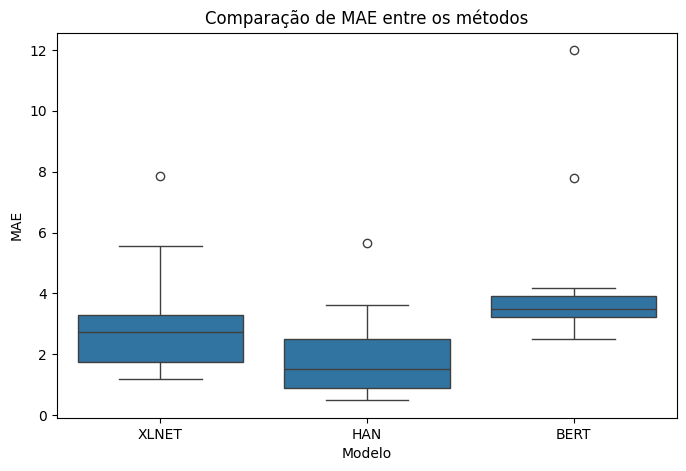

In [ ]:
df = pd.DataFrame(data_mae)
df_melted = df.melt(id_vars='Project', var_name='Modelo', value_name='MAE')
df_melted = df.melt(id_vars='Project', var_name='Modelo', value_name='MAE')
df_melted = df.melt(id_vars='Project', var_name='Modelo', value_name='MAE')

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x='Modelo', y='MAE')
plt.title('Comparação de MAE entre os métodos')
plt.show()

In [31]:
# Wilcoxon ESApp vs HAN
wilcoxon_esapp_han = stats.wilcoxon(esapp_mae, han_mae)
# Wilcoxon ESApp vs BERT
wilcoxon_esapp_bert = stats.wilcoxon(esapp_mae, bert_mae)

print("Wilcoxon ESApp vs HAN:", wilcoxon_esapp_han)
print("Wilcoxon ESApp vs BERT:", wilcoxon_esapp_bert)


Wilcoxon ESApp vs HAN: WilcoxonResult(statistic=0.0, pvalue=3.0517578125e-05)
Wilcoxon ESApp vs BERT: WilcoxonResult(statistic=3.0, pvalue=0.000152587890625)


In [32]:
def cohens_d(x, y):
    x = np.array(x)
    y = np.array(y)
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*x.std(ddof=1)**2 + (ny - 1)*y.std(ddof=1)**2) / (nx + ny - 2))
    return abs(x.mean() - y.mean()) / pooled_std

d_esapp_han = cohens_d(esapp_mae, han_mae)
d_esapp_bert = cohens_d(esapp_mae, bert_mae)

print("Cohen's d ESApp vs HAN:", d_esapp_han)
print("Cohen's d ESApp vs BERT:", d_esapp_bert)


Cohen's d ESApp vs HAN: 0.743057935793287
Cohen's d ESApp vs BERT: 0.5916908722886237


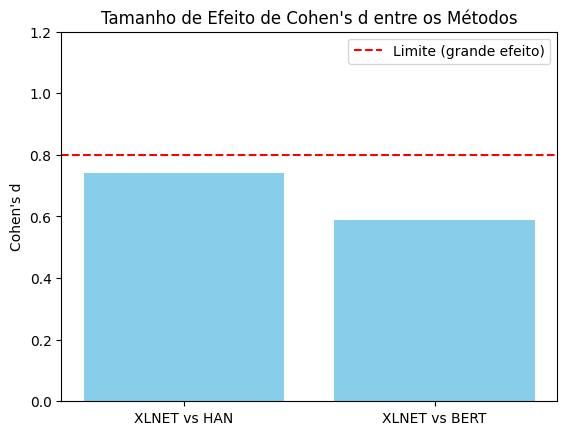

In [ ]:
#grafico Cohen
import matplotlib.pyplot as plt

methods = ['XLNET vs HAN', 'XLNET vs BERT']
cohen_d = [0.74, 0.59] #valores 

plt.bar(methods, cohen_d, color='skyblue')
plt.axhline(0.8, color='red', linestyle='--', label='Limite (grande efeito)')
plt.ylabel("Cohen's d")
plt.title("Tamanho de Efeito de Cohen's d entre os Métodos")
plt.legend()
plt.ylim(0, 1.2)
plt.show()

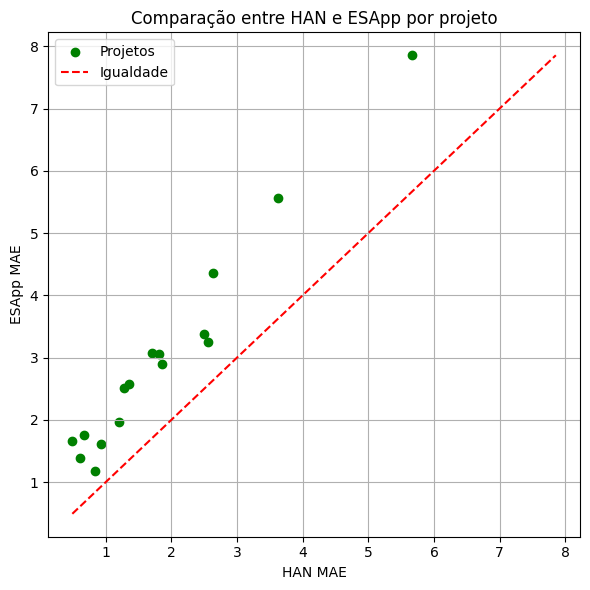

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd



# Converta as colunas para float (forçando erro se não for possível)
df['HAN'] = pd.to_numeric(df['HAN'], errors='coerce')
df['ESApp'] = pd.to_numeric(df['ESApp'], errors='coerce')


df.dropna(subset=['HAN', 'ESApp'], inplace=True)

#gráfico de dispersão
plt.figure(figsize=(6, 6))
plt.scatter(df['HAN'], df['ESApp'], label='Projetos', color='green')

#Linha de igualdade (x = y)
min_val = min(df['HAN'].min(), df['ESApp'].min())
max_val = max(df['HAN'].max(), df['ESApp'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Igualdade')

plt.xlabel('HAN MAE')
plt.ylabel('ESApp MAE')
plt.title('Comparação entre HAN e ESApp por projeto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
